# Attribution

### Find high attribution feature with Saliency.

In [40]:
import torch
import numpy as np
from captum.attr import Saliency

from networks import resnext50_32x4d
import torch.nn as nn
from data_loaders import *

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.ndimage.filters import gaussian_filter

import warnings
warnings.filterwarnings("ignore")

In [41]:
def get_Atrrmap(file_path):
    PATH = 'ckpt/MacroNet.pth'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = resnext50_32x4d()
    model = torch.load(PATH)
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
    model = model.to(device)
    model.eval()

    seg_filepaths = [file_path]
    for seg_filepath in seg_filepaths:

        input_npy = np.load(seg_filepath)
        train_transform = A.Compose(
            [   
                A.Resize(512, 512),
                A.Normalize(mean=(0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5), std=(0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5)),
                ToTensorV2(),
            ]
        )

        transformed = train_transform(image=input_npy)
        transformed_image = transformed["image"]
        input_tensor = transformed_image.unsqueeze(0).float()

        saliency = Saliency(model)
        Attrmap = saliency.attribute(input_tensor, target=None,abs=False)
    
    return Attrmap

In [42]:
def vis(seg_filepath,attributions_ig):
    prob_matrix = np.load(seg_filepath)
    multi_classes = np.zeros((prob_matrix.shape[0],prob_matrix.shape[1]))

    for i in range(prob_matrix.shape[0]):

        for j in range(prob_matrix.shape[1]):
            multi_classes[i][j] = np.argmax(prob_matrix[i,j,:])

            if prob_matrix[i,j,0] == 0 and multi_classes[i][j] == 0:
                multi_classes[i][j] = 1

    #get attribute
    a = attributions_ig.detach().numpy()
    a = np.squeeze(a)
    a = abs(a).sum(axis = 0)
    a = a/np.percentile(a.flatten(), 95)
    a = gaussian_filter(a, sigma=1)
 

    plt.figure(figsize=(4,4))
    plt.xticks(())
    plt.yticks(())
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    attri_map = np.squeeze(a)

    b = ["#FF0000", "#FFFFFF", "#9400D3", "#808080", "#FF69B4", "#98FB98","#00BFFF","#FFA500"]
    flatui = b
    sns.set_palette(flatui)
    segmap = multi_classes
    cmap = ListedColormap(flatui)
 
    plt.imshow(segmap, cmap = cmap, interpolation = 'nearest')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    alphas = np.clip(attri_map, .7, 1)
    plt.imshow(attri_map,cmap='gray',alpha=1-alphas,extent=(xmin,xmax,ymin,ymax))
    
    return None

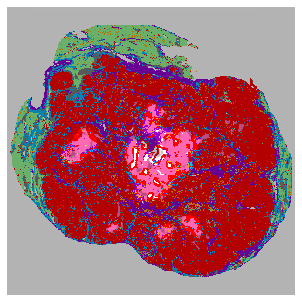

In [43]:
file_path = 'segmap/1.npy'
attrmap = get_Atrrmap(file_path)
vis(file_path, attrmap)

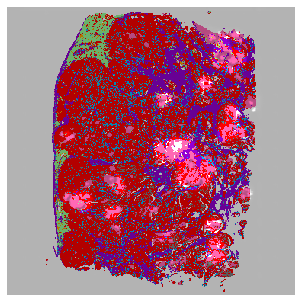

In [44]:
file_path = 'segmap/2.npy'
attrmap = get_Atrrmap(file_path)
vis(file_path, attrmap)

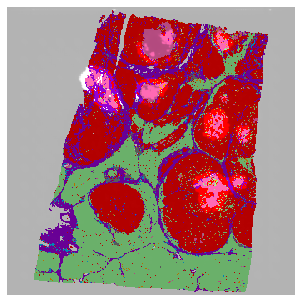

In [45]:
file_path = 'segmap/3.npy'
attrmap = get_Atrrmap(file_path)
vis(file_path, attrmap)

# Characterization

### TND and NEC are inspired by above attribution heatmaps.

#### TND calculation and comparison with attribution heatmaps

In [67]:
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def Co_loc(prob_map, cell_size):
    # prob_map: MxNx8 numpy array contains the probabilities
    # cell_size: number of patch to be consider as one grid-cell

    pred_map = np.load(prob_map)
    multi_classes = np.zeros((pred_map.shape[0],pred_map.shape[1]))

    for i in range(pred_map.shape[0]):

        for j in range(pred_map.shape[1]):
            multi_classes[i][j] = np.argmax(pred_map[i,j,:])

            if pred_map[i,j,0] == 0 and multi_classes[i][j] == 0:
                multi_classes[i][j] = 1
                
    pred_map = np.pad(multi_classes, np.int32(cell_size), pad_with)

    T = np.int8(pred_map == 0)  # patches predicted as tumour
    # L = np.int8(pred_map == 3)  # patches predicted as lymphocyte
    L = np.int8(pred_map == 4)  # patches predicted as necrosis

    [rows, cols] = T.shape
    stride = np.int32(cell_size / 2)

    rows_new = len(range(0, rows - cell_size + 1, stride))
    cols_new = len(range(0, cols - cell_size + 1, stride))

    t = np.zeros(rows_new * cols_new)
    l = np.zeros(rows_new * cols_new)

    co_loc = np.zeros(rows_new * cols_new)
    k = 0

    # probability of tumour and lymphocytes in each grid cell
    for i in range(0, rows - cell_size + 1, stride):
        for j in range(0, cols - cell_size + 1, stride):
            t[k] = np.mean(np.mean(T[i:i + cell_size, j:j + cell_size]))
            l[k] = np.mean(np.mean(L[i:i + cell_size, j:j + cell_size]))
            if (t[k] != 0)&(l[k] != 0):
                lt_ratio = 0.5*l[k]/t[k]
                co_loc[k] = 2*t[k]*l[k]*lt_ratio/(t[k]**2 + l[k]**2)
                # co_loc[k] = 2*t[k]*l[k]/(t[k]**2 + l[k]**2)
            k += 1

    co_loc = np.array(co_loc).reshape(rows_new,cols_new)

    return co_loc

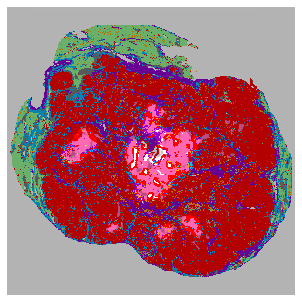

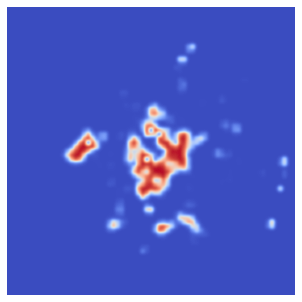

In [73]:
file_path = 'segmap/1.npy'
attrmap = get_Atrrmap(file_path)
vis(file_path, attrmap)


TND = Co_loc(prob_map = file_path , cell_size = 10)
plt.figure(figsize=(4, 4))
plt.xticks(())
plt.yticks(())
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(TND,cmap='coolwarm',interpolation='gaussian')

#### NEC calculation and comparison with attribution heatmaps

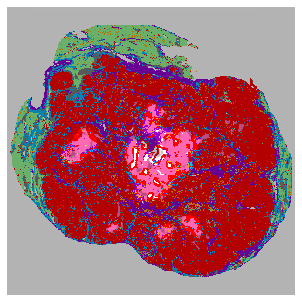

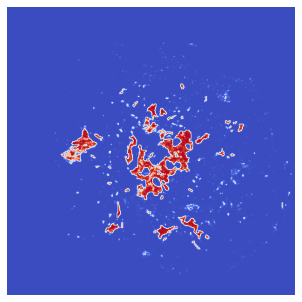

In [75]:
file_path = 'segmap/1.npy'
attrmap = get_Atrrmap(file_path)
vis(file_path, attrmap)


prob_matrix = np.load(file_path)
NEC = prob_matrix[:,:,4]
plt.figure(figsize=(4,4))
plt.xticks(())
plt.yticks(())
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.axis('off')
plt.imshow(NEC, cmap = 'coolwarm', interpolation = 'gaussian')